# Construcción aplicada de un sistema de Query Answering


En este notebook vamos a construir un sistema de Query Answering usando la técnica RAG para que responda preguntas sobre el libro `El principito`. Para ello, primero vamos a construir un dataset a partir del libro y, posteriormente, construir el sistema usando las clases vistas en los notebooks anteriores.

In [1]:
from huggingface_hub import login
token = ""
print("Hugging Face logging")
login(token)

Hugging Face logging


In [2]:
import torch
device_setup = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print("Using: ", device_setup)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Using:  cpu





#### Tarea QAC1 - Dataset
Lo primero que necesitamos hacer es preparar la base documental con la que alimentaremos nuestro RAG. Para ello, vamos a leer el PDF del libro y vamos a dividirlo en documentos relevantes que pueden ser frases, parrafos, etc. Para leer el fichero pdf podemos usar la libreria `pdfplumber`. Por otro lado, el libro se encuentra en la carpeta `./provided/el_principito.pdf`

In [3]:
import pdfplumber


# DONE: Leer el fichero PDF y partirlo en documentos relevantes
def extract_text_with_page_numbers(pdf_path):
    page_texts = {}
    with pdfplumber.open(pdf_path) as pdf:
        for i, page in enumerate(pdf.pages, start=1):
            text = page.extract_text()
            page_texts[i] = text
    return page_texts

def extract_text_with_pdfplumber(pdf_path):
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text()
    return text

# Ejemplo de uso
pdf_path = "./provided/el_principito.pdf"
pdf_text = extract_text_with_pdfplumber(pdf_path)
documents = pdf_text.split('.')
print("Tamaño del corpus documental: ",len(documents))


Tamaño del corpus documental:  1144


### Preguntas y respuestas para la evaluación

A continuación, vamos a utilizar las siguientes preguntas y respuestas para evaluar el modelo. Las preguntas han sido escogidas aleatoriamente de distintos exámenes tipo test online sobre el libro.

In [5]:

questions = {
	1 : "¿El Principito vive en un asteroide?",
	2 : "¿El asteroide se llama B-612?",
	3 : "¿El Principito tiene una flor que cuida mucho?",
	4 : "¿La flor del Principito es una rosa?",
	5 : "¿El Principito se encuentra con un zorro en la Tierra?",
	6 : "¿El zorro le enseña al Principito sobre la amistad?",
	7 : "¿El aviador arregla su avión durante la historia?",
	8 : "¿El Principito considera los baobabs una amenaza para su asteroide?",
	9 : "¿El Principito piensa que los adultos siempre entienden las cosas importantes?",
	10 : "¿El Principito regresa a su asteroide al final del libro?"
}

responses = {
    1 : "Si.",
    2 : "Si.",
    3 : "Si.",
    4 : "Si.",
    5 : "Si.",
    6 : "Si.",
    7 : "Si.",
    8 : "Si.",
    9 : "No.",
    10 : "Implícitamente, si."
}

## Evaluar los modelos usando el dataset y el libro

A continuación vamos a importar las clases necesarias para crear nuestro sistema de Question Answering re-uilizando las clases vistas en notebooks anteriores. En particular:

* `LLMModel`: es la clase para construir un LLM que responda las preguntas usando contexto
* `QuestionAnsweringFactory`: clase estática que nos devuelve un array de tuplas con todos los sistemas QuestionAnswering que se pueden construir usando los retrievers vistos en clase. El primer elemento de la tupla es el nombre y el segundo el modelo.
    * QuestionAnsweringFactory.get_models(generator, documents)
* `evaluate_qa_answers` dado un conjunto de respuestas generadas y de respuestas esperadas calcula las métricas de eficiencia vistas en notebooks anteriores

In [6]:
from libs.qa_lib import QuestionAnsweringFactory
from libs.rag_lib import LLMModel
from libs.qa_lib import evaluate_qa_answers


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Tarea QAC2.1

Escribir el código necesario para que un modelo LLM basado en `TinyLlama/TinyLlama-1.1B-Chat-v1.0` responsa cada pregunta del dataset. Imprima por pantalla la pregunta, la respuesta esperada, y la generada

In [7]:
answers = {}
llm_model = LLMModel()

In [8]:
for idx, question in questions.items():
    answer = llm_model.answer(question, "", use_context=False)
    print("Question: ", question)
    print("expected answer: ", responses[idx])
    print("answer: ", answer)
    print("________________")
    answers['no_context'] = {idx : answer}

Question:  ¿El Principito vive en un asteroide?
expected answer:  Si.
answer:  Sí, El Principito vive en un asteroide. El asteroide es un objeto natural que orbita la Tierra y no es un planeta. El Principito es un asteroide de la familia de los asteroides de la Tierra, que se encuentra a 1,260 AU (1,490 millones de kilómetros) del Sol.
________________
Question:  ¿El asteroide se llama B-612?
expected answer:  Si.
answer:  Sí, el asteroide B-612 es un asteroide de la tribu de los asteroides de tipo Chamaeleo. El nombre B-612 se refiere a la tribu de asteroides que lleva este nombre, y el asteroide se llama así en honor a la tribu de asteroides que lleva este nombre.
________________
Question:  ¿El Principito tiene una flor que cuida mucho?
expected answer:  Si.
answer:  Sí, El Principito tiene una flor que cuida mucho. El Principito es un personaje de la novela "El Principito" de Rafael Alberti, publicada en 1913. La flor que cuida mucho es la flor de la madre de El Principito, que se 

#### Tarea QAC2.2

Escribir el código necesario para que un modelo de Question Answering basado en `TinyLlama/TinyLlama-1.1B-Chat-v1.0` responsa cada pregunta del dataset. Imprima por pantalla la pregunta, la respuesta esperada, y la generada. Pruebe a variar la temperatura y observar las distintas respuestas.

In [9]:
models = QuestionAnsweringFactory.get_models(generator=llm_model, documents=documents)
model = models[0][1] # Sparse

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

In [10]:
# TODO: variar el top_k y la temperatura para mostrar como pueden mejorar las respuestas
for idx, question in questions.items():
    answer = model.answer(question, lang="spanish" ,temperature=0.1)
    print("Question: ", question)
    print("expected answer: ", responses[idx])
    print("answer: ", answer)
    print("________________")
    answers['lower_tmp'] = {idx : answer}


Question:  ¿El Principito vive en un asteroide?
expected answer:  Si.
answer:  Sí, el Principito vive en un pequeñísimo asteroide, el asteroide B 612. El principito es un pequeño animal de la familia de los insectos, que vive en un pequeñísimo asteroide llamado B 612. El asteroide B 612 es un asteroide pequeño y pequeñísimo, que comparte con una flor caprichosa y tres volcanes. El principito vive en Francia, donde tiene hambre y frío. El principito tiene una tercera excusa: su nombre es "el asteroide 3251".
________________
Question:  ¿El asteroide se llama B-612?
expected answer:  Si.
answer:  The given context does not provide a clear answer to the question "Is the asteroid B-612 named after a person?" Therefore, I will not be able to provide a short answer. However, based on the given information, it is possible that the asteroid B-612 is named after a person. However, this information is not explicitly stated in the given context, and it is up to the reader to determine the answer 

In [11]:
for idx, question in questions.items():
    answer = model.answer(question, lang="spanish", do_sample=True, show_prompt=False,temperature=0.7)
    print("Question: ", question)
    print("expected answer: ", responses[idx])
    print("answer: ", answer)
    print("________________")
    answers['mid_tmp'] = {idx : answer}

Question:  ¿El Principito vive en un asteroide?
expected answer:  Si.
answer:  Based on the given context, the question can be answered with the following short answer:

Yes, the Principito lives on an asteroid.
________________
Question:  ¿El asteroide se llama B-612?
expected answer:  Si.
answer:  Yes, according to the given context, the asteroid B-612 is the smallest and most volatile planet in the Solar System. The asteroid's tiny size and volatile nature make it a small planet, as opposed to the larger and more stable planets like Jupiter, Saturn, Uranus, and Neptune. It is believed to have formed from the collision of two smaller asteroids around 4.5 billion years ago. The small size and volatile nature of the asteroid make it a fascinating and enigmatic object that has captured the imagination of astronomers and the public alike.
________________
Question:  ¿El Principito tiene una flor que cuida mucho?
expected answer:  Si.
answer:  The following information is sufficient to an

In [12]:
for idx, question in questions.items():
    answer = model.answer(question, lang="spanish", temperature=1)
    print("Question: ", question)
    print("expected answer: ", responses[idx])
    print("answer: ", answer)
    print("________________")
    answers['high_tmp'] = {idx : answer}


Question:  ¿El Principito vive en un asteroide?
expected answer:  Si.
answer:  The given context does not provide sufficient information to answer the question "Why is the Principito living in an asteroide?" without any prior knowledge. Therefore, "I do not know" would be an appropriate answer.
________________
Question:  ¿El asteroide se llama B-612?
expected answer:  Si.
answer:  The given context cannot be used to answer the question as it does not provide any information regarding whether the asteroid with the name "B-612" is mentioned. Therefore, based on the information presented in the given context, the answer is either "No" or "Yes" as stated in the short answer.
________________
Question:  ¿El Principito tiene una flor que cuida mucho?
expected answer:  Si.
answer:  Sure, I can provide a short answer to this question based on the given context. The Principito's flower, although small, seems to take great care of it and is probably a popular plant among the surrounding wildlif

#### Tarea QAC3

Evalúe los dos modelos anteriores para ello utilice las funciones vistas en los notebooks anteriores

{'no_context': {'bleu': 0.0, 'rouge': {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}, 'meteor': 0.0, 'exact_match': 0.0, 'f1': 0.0, 'cosine_similarity': 0.0}, 'lower_tmp': {'bleu': 0.0, 'rouge': {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}, 'meteor': 0.0, 'exact_match': 0.0, 'f1': 0.0, 'cosine_similarity': 0.0}, 'mid_tmp': {'bleu': 0.0, 'rouge': {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}, 'meteor': 0.0, 'exact_match': 0.0, 'f1': 0.0, 'cosine_similarity': 0.0}, 'high_tmp': {'bleu': 0.0, 'rouge': {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}, 'meteor': 0.0, 'exact_match': 0.0, 'f1': 0.0, 'cosine_similarity': 0.0}}


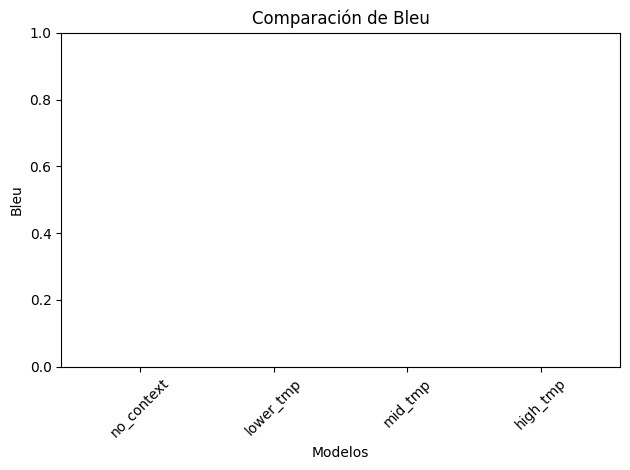

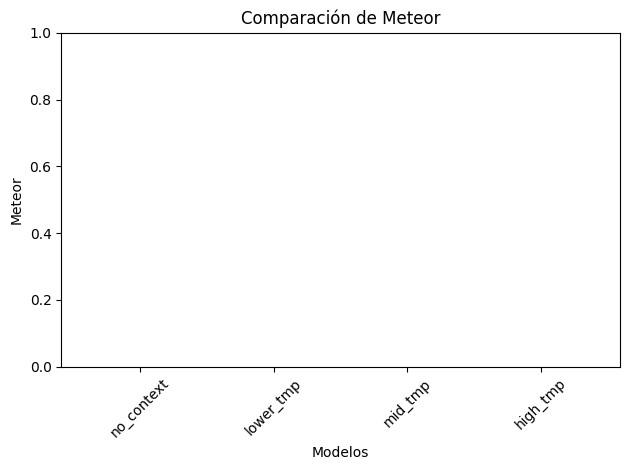

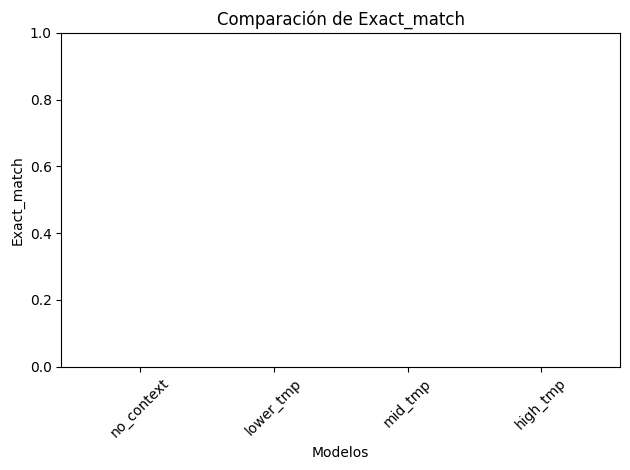

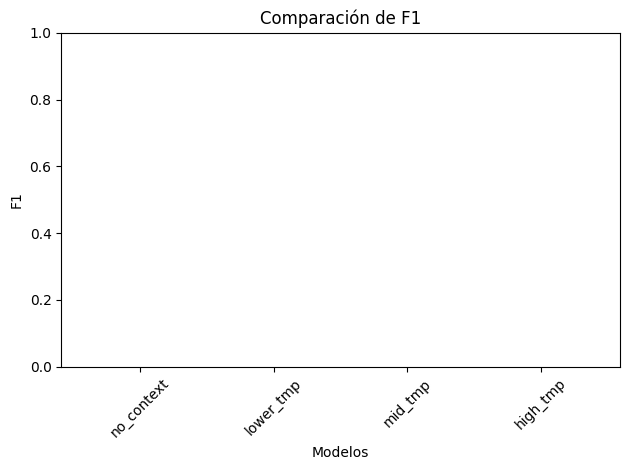

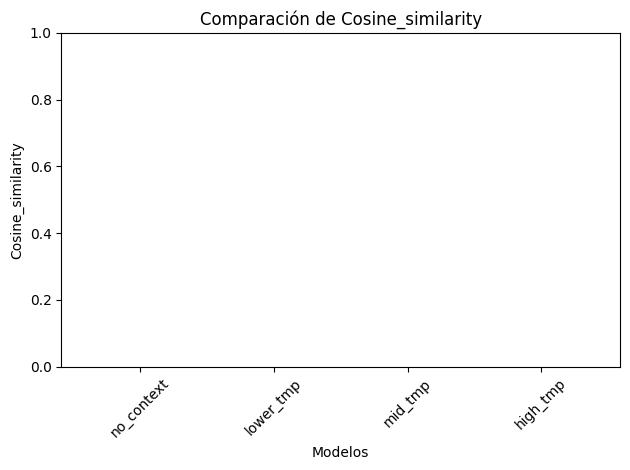

In [13]:
from libs.rag_lib import plot_evaluation_results

results = evaluate_qa_answers(answers, responses)
print(results)
plot_evaluation_results(results)